#  **Neighborhood Search for International students in London**

###   **Table of Contents**

- [Introduction to the Business Problem](#1.Introduction-to-the-Business-Problem)
- [Data](#2.Data)
- [Methodology](#3.Methodology)
- [Results & Discussion](#4.Results-&-Discussion)
- [Conclusion](#5.Conclusion)

## **`1.Introduction to the Business Problem`**

With its world-recognised universities, culturally diverse environment, and highly-skilled academic staff, the UK is consistently increasing in popularity to international students. 
According to 2018/2019 statistics from the Higher Education Statistics Agency, 485,645 international students were pursuing their degree in the UK, of which 125,035 were studying in the capital- `London`. Among other challenges faced by the students, one is selecting a Neighborhood in close vicinity of the Institute, based on their preferences. When I came to London to pursue my masters, I faced the same situation. While there are apps and websites where you can find the nearby postcodes, there is no central repository that specifies what places are there in each of those neighborhoods.

In this project, I will addressing this situation by exploring the Neighborhoods in the vicinity of a particular college. The solution is designed for the international candidates moving to London for pursuing their studies.
Coming from a technology background and transitioning into the world of Data Science, this project is the stepping stone, utilising the knowledge gained through the IBM Data Science Certification course

## **`2.Data`**

For this project I need the following data: 
- `Geolocation data of the Universities in UK`:
UK Learning Providers(http://learning-provider.data.ac.uk/) provides all universities in UK data along with the GeoLocations. From this I will extract only the universities of London for this project.
<br> Example data:
<br> <img src="University_data.png" width =600/>
<br>
<br>
- `London Postal Codes`: 
List of all London Postcodes along with their Borough and geo data is available at https://www.doogal.co.uk/PostcodeDownloads.php. I will need to get the pre-fixes of the postcodes and group them.
<br> Example data:
<br> ![image](https://user-images.githubusercontent.com/62149395/79698985-5addca00-8284-11ea-8b2f-28cf23eed76a.png)
<br>
<br>
- `Public Transport Accessibility Level data`:Transport for London (TfL – the transport authority for London) has developed a tool that rates the accessibility of locations across London to public transport. The Public Transport Accessibility Level (PTAL) assesses the level of walking distances to transport stops and stations, including measuring the level of transport service and wider connectivity. This data for the area is available at https://data.london.gov.uk/dataset/public-transport-accessibility-levels Each area is graded between 0 and 6b, where a score of 0 is very poor access to public transport, and 6b is excellent access to public transport.
<br> Example data:
<br> ![image](https://user-images.githubusercontent.com/62149395/79698898-f02c8e80-8283-11ea-8703-246bde00cdff.png)
<br>
<br>
- `Neighborhoods within 5kms of the Institute`: https://postcodes.io/ provides an API which when called, generates a JSON with data of outcodes(Postcost area and postcode District) within 5km of a given Postcode. I will use the API to get the Outcodes of the neighborhoods.
<br>
<br>
- `Venues in Neighborhood`: This data is obtained using the Foursquare API. Using the geo data of an Area we explore using the API to get the venue nearby each of the neighborhood

## **`3.Methodology`**

#### *Installing the Libraries* 

In [1]:
!pip install geopy
!pip -q install folium

     |████████████████████████████████| 112kB 6.4MB/s eta 0:00:01


In [2]:
import numpy as np 
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use(['ggplot'])

import json
import requests 
from pandas.io.json import json_normalize 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

from collections import Counter
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
#
print('Libraries imported.')

Libraries imported.


### <ins>Read **Postcode Data** and extract relevant features</ins>

In [3]:
London_Postcode_data = pd.read_csv('London postcodes.csv', engine= 'python')
London_Postcode_data.head()

,Postcode,In Use?,Latitude,Longitude,Easting,Northing,Grid Ref,County,District,Ward,...,User Type,Last updated,Nearest station,Distance to station,Postcode area,Postcode district,Police force,Water company,Plus Code,Average Income
0,BR1 1AA,Yes,51.401546,0.015415,540291,168873,TQ402688,Greater London,Bromley,Bromley Town,...,0,2020-02-19,Bromley South,0.218257,BR,BR1,Metropolitan Police,Thames Water,9F32C228+J5,63100
1,BR1 1AB,Yes,51.406333,0.015208,540262,169405,TQ402694,Greater London,Bromley,Bromley Town,...,0,2020-02-19,Bromley North,0.253666,BR,BR1,Metropolitan Police,Thames Water,9F32C248+G3,56100
2,BR1 1AD,No,51.400057,0.016715,540386,168710,TQ403687,Greater London,Bromley,Bromley Town,...,1,2020-02-19,Bromley South,0.044559,BR,BR1,Metropolitan Police,NaN,9F32C228+2M,63100
3,BR1 1AE,Yes,51.404543,0.014195,540197,169204,TQ401692,Greater London,Bromley,Bromley Town,...,0,2020-02-19,Bromley North,0.462939,BR,BR1,Metropolitan Police,Thames Water,9F32C237+RM,63100
4,BR1 1AF,Yes,51.401392,0.014948,540259,168855,TQ402688,Greater London,Bromley,Bromley Town,...,0,2020-02-19,Bromley South,0.227664,BR,BR1,Metropolitan Police,Thames Water,9F32C227+HX,63100


In [4]:
print(London_Postcode_data.shape)
London_Postcode_data.describe(include = "all")

(321834, 47)


,Postcode,In Use?,Latitude,Longitude,Easting,Northing,Grid Ref,County,District,Ward,...,User Type,Last updated,Nearest station,Distance to station,Postcode area,Postcode district,Police force,Water company,Plus Code,Average Income
count,321834,321834,321834.000000,321834.000000,321834.000000,321834.000000,321834,321834,321834,321834,...,321834.000000,321834,321834,321834.000000,321834,321834,321834,183996,321834,321834.000000
unique,321834,2,NaN,NaN,NaN,NaN,83560,2,33,638,...,NaN,1,641,NaN,22,329,2,8,190432,NaN
top,SW19 1EB,Yes,NaN,NaN,NaN,NaN,TQ310823,Greater London,Westminster,West End,...,NaN,2020-02-19,Chancery Lane,NaN,W,SE1,Metropolitan Police,Thames Water,9C3XGVFQ+R5,NaN
freq,1,178631,NaN,NaN,NaN,NaN,3150,315035,31085,12650,...,NaN,321834,4358,NaN,39642,3652,315035,152824,3150,NaN
mean,NaN,NaN,51.507526,-0.132063,529732.430604,180395.905187,NaN,NaN,NaN,NaN,...,0.445282,NaN,NaN,0.580607,NaN,NaN,NaN,NaN,NaN,54739.556728
std,NaN,NaN,0.069305,0.140120,9724.543847,7711.072999,NaN,NaN,NaN,NaN,...,0.496998,NaN,NaN,0.475774,NaN,NaN,NaN,NaN,NaN,8547.329352
min,NaN,NaN,51.293401,-0.499204,503978.000000,156844.000000,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,36000.000000
25%,NaN,NaN,51.466397,-0.209170,524387.000000,175859.250000,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,0.268101,NaN,NaN,NaN,NaN,NaN,48600.000000
50%,NaN,NaN,51.513959,-0.132029,529722.000000,181106.000000,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,0.461470,NaN,NaN,NaN,NaN,NaN,54000.000000
75%,NaN,NaN,51.552671,-0.058608,534763.000000,185500.000000,NaN,NaN,NaN,NaN,...,1.000000,NaN,NaN,0.753468,NaN,NaN,NaN,NaN,NaN,59700.000000


In [5]:
London_Postcode_filtered = London_Postcode_data[['Postcode','In Use?','Latitude','Longitude','District','Postcode district','LSOA Code']]
print(London_Postcode_filtered.shape)
London_Postcode_filtered.describe(include = "all")

(321834, 7)


,Postcode,In Use?,Latitude,Longitude,District,Postcode district,LSOA Code
count,321834,321834,321834.000000,321834.000000,321834,321834,321834
unique,321834,2,NaN,NaN,33,329,4835
top,SW19 1EB,Yes,NaN,NaN,Westminster,SE1,E01032739
freq,1,178631,NaN,NaN,31085,3652,4498
mean,NaN,NaN,51.507526,-0.132063,NaN,NaN,NaN
std,NaN,NaN,0.069305,0.140120,NaN,NaN,NaN
min,NaN,NaN,51.293401,-0.499204,NaN,NaN,NaN
25%,NaN,NaN,51.466397,-0.209170,NaN,NaN,NaN
50%,NaN,NaN,51.513959,-0.132029,NaN,NaN,NaN
75%,NaN,NaN,51.552671,-0.058608,NaN,NaN,NaN


#### *Removing 'Not-in-use' Postcodes*

In [6]:
London_Postcode_filtered= London_Postcode_filtered[London_Postcode_filtered['In Use?'] == 'Yes'].reset_index(drop=True)
print(London_Postcode_filtered.shape)
London_Postcode_filtered.head()

(178631, 7)


,Postcode,In Use?,Latitude,Longitude,District,Postcode district,LSOA Code
0,BR1 1AA,Yes,51.401546,0.015415,Bromley,BR1,E01000675
1,BR1 1AB,Yes,51.406333,0.015208,Bromley,BR1,E01000676
2,BR1 1AE,Yes,51.404543,0.014195,Bromley,BR1,E01000677
3,BR1 1AF,Yes,51.401392,0.014948,Bromley,BR1,E01000675
4,BR1 1AG,Yes,51.401392,0.014948,Bromley,BR1,E01000675


In [7]:
London_Postcode_filtered.isnull().sum().sum()

0

> *Confirms there are no missing values in the dataset*

In [8]:
London_Postcode_groupby = London_Postcode_filtered.groupby('Postcode district',as_index = False).apply(lambda x: x.reset_index(drop = True)).reset_index()
London_Postcode_groupby.drop(['level_0','level_1','In Use?'],axis=1,inplace= True)
London_Postcode_groupby.head()

,Postcode,Latitude,Longitude,District,Postcode district,LSOA Code
0,BR1 1AA,51.401546,0.015415,Bromley,BR1,E01000675
1,BR1 1AB,51.406333,0.015208,Bromley,BR1,E01000676
2,BR1 1AE,51.404543,0.014195,Bromley,BR1,E01000677
3,BR1 1AF,51.401392,0.014948,Bromley,BR1,E01000675
4,BR1 1AG,51.401392,0.014948,Bromley,BR1,E01000675


In [9]:
London_Postcode_groupby.dtypes

Postcode              object
Latitude             float64
Longitude            float64
District              object
Postcode district     object
LSOA Code             object
dtype: object

> *The datatypes of the features of Postcode dataframe look fine*

#### *Extracting the Area code for each Postcode*

In [10]:
London_Postcode_groupby.reset_index(inplace = True, drop= True)
London_Postcode_groupby['Area_code'] = London_Postcode_groupby['Postcode'].astype(str).str[0:5]
London_Postcode_groupby.head()

,Postcode,Latitude,Longitude,District,Postcode district,LSOA Code,Area_code
0,BR1 1AA,51.401546,0.015415,Bromley,BR1,E01000675,BR1 1
1,BR1 1AB,51.406333,0.015208,Bromley,BR1,E01000676,BR1 1
2,BR1 1AE,51.404543,0.014195,Bromley,BR1,E01000677,BR1 1
3,BR1 1AF,51.401392,0.014948,Bromley,BR1,E01000675,BR1 1
4,BR1 1AG,51.401392,0.014948,Bromley,BR1,E01000675,BR1 1


#### *Aggregrating the Geo data for each Area code, to derive the approx longitude and latitude*

In [11]:
London_Postcode_grp = London_Postcode_groupby.groupby(['Area_code'],as_index = False).agg({'Latitude':'mean','Longitude':'mean'})

In [12]:
print(London_Postcode_grp.shape)
London_Postcode_grp.head()

(2744, 3)


,Area_code,Latitude,Longitude
0,BR1 1,51.404491,0.015505
1,BR1 2,51.401544,0.044331
2,BR1 3,51.409690,0.019318
3,BR1 4,51.418943,0.006019
4,BR1 5,51.427667,0.010814


#### *Drop duplicate Area codes to have single entry corresponding to each area code*

In [13]:
London_Postcode_groupby= London_Postcode_groupby.drop_duplicates(subset='Area_code', keep='first')
London_Postcode_groupby.reset_index(inplace = True, drop= True)
print(London_Postcode_groupby.shape)
London_Postcode_groupby.head()

(2744, 7)


,Postcode,Latitude,Longitude,District,Postcode district,LSOA Code,Area_code
0,BR1 1AA,51.401546,0.015415,Bromley,BR1,E01000675,BR1 1
1,BR1 2AA,51.403386,0.043619,Bromley,BR1,E01000645,BR1 2
2,BR1 3AA,51.406882,0.020438,Bromley,BR1,E01000825,BR1 3
3,BR1 4AA,51.410171,0.006936,Bromley,BR1,E01000674,BR1 4
4,BR1 5AA,51.420290,0.019418,Bromley,BR1,E01000819,BR1 5


In [14]:
London_Postcode_groupby.rename(columns = {'Postcode district':'Outcode'},
                                 inplace = True) 
London_Postcode_groupby.shape

(2744, 7)

In [15]:
London_Postcode_groupby= pd.merge(London_Postcode_groupby, London_Postcode_grp, on='Area_code', how='left')
London_Postcode_groupby.head()

,Postcode,Latitude_x,Longitude_x,District,Outcode,LSOA Code,Area_code,Latitude_y,Longitude_y
0,BR1 1AA,51.401546,0.015415,Bromley,BR1,E01000675,BR1 1,51.404491,0.015505
1,BR1 2AA,51.403386,0.043619,Bromley,BR1,E01000645,BR1 2,51.401544,0.044331
2,BR1 3AA,51.406882,0.020438,Bromley,BR1,E01000825,BR1 3,51.409690,0.019318
3,BR1 4AA,51.410171,0.006936,Bromley,BR1,E01000674,BR1 4,51.418943,0.006019
4,BR1 5AA,51.420290,0.019418,Bromley,BR1,E01000819,BR1 5,51.427667,0.010814


In [16]:
London_Postcode_groupby = London_Postcode_groupby.drop(['Longitude_x','Latitude_x'],1)
London_Postcode_groupby.head()

,Postcode,District,Outcode,LSOA Code,Area_code,Latitude_y,Longitude_y
0,BR1 1AA,Bromley,BR1,E01000675,BR1 1,51.404491,0.015505
1,BR1 2AA,Bromley,BR1,E01000645,BR1 2,51.401544,0.044331
2,BR1 3AA,Bromley,BR1,E01000825,BR1 3,51.409690,0.019318
3,BR1 4AA,Bromley,BR1,E01000674,BR1 4,51.418943,0.006019
4,BR1 5AA,Bromley,BR1,E01000819,BR1 5,51.427667,0.010814


#### *Final Postcode Dataset with relevant features*

In [17]:
London_Postcode_groupby.rename(columns = {'Latitude_y':'Area_lat','Longitude_y':'Area_lng'},
                                 inplace = True) 
print(London_Postcode_groupby.shape)
London_Postcode_groupby.head()

(2744, 7)


,Postcode,District,Outcode,LSOA Code,Area_code,Area_lat,Area_lng
0,BR1 1AA,Bromley,BR1,E01000675,BR1 1,51.404491,0.015505
1,BR1 2AA,Bromley,BR1,E01000645,BR1 2,51.401544,0.044331
2,BR1 3AA,Bromley,BR1,E01000825,BR1 3,51.409690,0.019318
3,BR1 4AA,Bromley,BR1,E01000674,BR1 4,51.418943,0.006019
4,BR1 5AA,Bromley,BR1,E01000819,BR1 5,51.427667,0.010814


### <ins>Read the **PTAL File** and merge the PTAL with Postcode</ins>

In [18]:
London_PubTrans_data = pd.read_csv('Public Trans Accessibility Level.csv', engine= 'python')
London_PubTrans_data.head()

,LSOA2011,AvPTAI2015,PTAL,PTAIHigh,PTAILow
0,E01000001,69.8233,6b,97.4435,35.9190
1,E01000002,83.7820,6b,117.9120,66.3503
2,E01000003,41.7417,6b,49.5318,37.3635
3,E01000005,85.8893,6b,120.8470,45.9168
4,E01000006,22.4558,5,34.1054,0.0000


In [19]:
London_Postcode_groupby= London_Postcode_groupby.merge(London_PubTrans_data[['LSOA2011', 'PTAL']], 
                                                           left_on='LSOA Code', right_on='LSOA2011')
London_Postcode_groupby.head()

,Postcode,District,Outcode,LSOA Code,Area_code,Area_lat,Area_lng,LSOA2011,PTAL
0,BR1 1AA,Bromley,BR1,E01000675,BR1 1,51.404491,0.015505,E01000675,5
1,BR1 2AA,Bromley,BR1,E01000645,BR1 2,51.401544,0.044331,E01000645,1b
2,BR1 3AA,Bromley,BR1,E01000825,BR1 3,51.409690,0.019318,E01000825,3
3,BR1 4AA,Bromley,BR1,E01000674,BR1 4,51.418943,0.006019,E01000674,3
4,BR1 5AA,Bromley,BR1,E01000819,BR1 5,51.427667,0.010814,E01000819,2


#### *Postcode Dataset with PTAL feature included*

In [20]:
London_Postcode_groupby = London_Postcode_groupby.drop(['LSOA Code','LSOA2011'],1)
London_Postcode_groupby.head()

,Postcode,District,Outcode,Area_code,Area_lat,Area_lng,PTAL
0,BR1 1AA,Bromley,BR1,BR1 1,51.404491,0.015505,5
1,BR1 2AA,Bromley,BR1,BR1 2,51.401544,0.044331,1b
2,BR1 3AA,Bromley,BR1,BR1 3,51.409690,0.019318,3
3,BR1 4AA,Bromley,BR1,BR1 4,51.418943,0.006019,3
4,BR1 5AA,Bromley,BR1,BR1 5,51.427667,0.010814,2


### <ins>Read the **UK institutions file** and extract **London** based Institutions</ins>

In [21]:
UK_inst_data = pd.read_csv('learning-providers-plus.csv')
print(UK_inst_data.shape)
UK_inst_data.head()

(166, 20)


,UKPRN,PROVIDER_NAME,VIEW_NAME,SORT_NAME,ALIAS,FLAT_NAME_NUMBER,BUILDING_NAME_NUMBER,LOCALITY,STREET_NAME,TOWN,POSTCODE,WEBSITE_URL,WIKIPEDIA_URL,GROUPS,LONGITUDE,LATITUDE,EASTING,NORTHING,GTR_ID,HESA_ID
0,10008640,FALMOUTH UNIVERSITY,University College Falmouth,"Falmouth, University College",NaN,NaN,Woodlane Campus,NaN,Woodlane,Falmouth,TR11 4RH,http://www.falmouth.ac.uk/,http://en.wikipedia.org/wiki/University_Colleg...,NaN,-5.070901,50.149168,180711.0,32196.0,E84FC550-A4CC-4B98-A6F9-D15A33829D83,17.0
1,10007774,UNIVERSITY OF OXFORD,University of Oxford,"Oxford, University of",NaN,NaN,UNIVERSITY OFFICES,NaN,WELLINGTON SQUARE,OXFORD,OX1 2JD,http://www.ox.ac.uk/,http://en.wikipedia.org/wiki/University_of_Oxford,"Science_and_Engineering_South, Russell_Group, ...",-1.262868,51.757644,450974.0,206807.0,B1F0E8FE-FE3C-49ED-9C96-1ED75312A8A0,156.0
2,10007768,UNIVERSITY OF LANCASTER,University of Lancaster,"Lancaster, University of",NaN,NaN,UNIVERSITY HOUSE,BAILRIGG,NaN,LANCASTER,LA1 4YW,http://www.lancs.ac.uk/,http://en.wikipedia.org/wiki/Lancaster_University,"1994_Group, N8_Research_Partnership",-2.786905,54.010480,348528.0,457448.0,F8C7F869-77D6-4859-96F1-3550A4951F6C,123.0
3,10000571,BATH SPA UNIVERSITY,Bath Spa University,Bath Spa University,NaN,NaN,NEWTON PARK,NEWTON ST. LOE,NaN,BATH,BA2 9BN,http://www.bathspa.ac.uk/,http://en.wikipedia.org/wiki/Bath_Spa_University,Million_Plus,-2.437400,51.378739,369654.0,164501.0,1A469850-02BA-4814-81EE-E60C851CABC3,48.0
4,10007814,CARDIFF UNIVERSITY,Cardiff University,Cardiff University,NaN,NaN,NaN,NaN,PARK PLACE,CARDIFF,CF10 3AT,http://www.cardiff.ac.uk/,http://en.wikipedia.org/wiki/Cardiff_University,"GW4, Russell_Group",-3.179907,51.489093,318176.0,177343.0,9C10D78F-6430-4CA7-9528-B96B0762A4C6,179.0


In [22]:
UK_institute_loc= UK_inst_data.drop(['UKPRN','SORT_NAME','ALIAS','FLAT_NAME_NUMBER', 
                                     'BUILDING_NAME_NUMBER', 'LOCALITY', 'STREET_NAME',
                                     'WEBSITE_URL', 'WIKIPEDIA_URL', 'GROUPS','EASTING', 
                                     'NORTHING', 'GTR_ID', 'HESA_ID'],1)

In [23]:
UK_institute_loc.head()

,PROVIDER_NAME,VIEW_NAME,TOWN,POSTCODE,LONGITUDE,LATITUDE
0,FALMOUTH UNIVERSITY,University College Falmouth,Falmouth,TR11 4RH,-5.070901,50.149168
1,UNIVERSITY OF OXFORD,University of Oxford,OXFORD,OX1 2JD,-1.262868,51.757644
2,UNIVERSITY OF LANCASTER,University of Lancaster,LANCASTER,LA1 4YW,-2.786905,54.010480
3,BATH SPA UNIVERSITY,Bath Spa University,BATH,BA2 9BN,-2.437400,51.378739
4,CARDIFF UNIVERSITY,Cardiff University,CARDIFF,CF10 3AT,-3.179907,51.489093


In [24]:
UK_institute_loc.isnull().sum().sum()

0

>  *Confirms there are no missing values in the extracted University dataset*

In [25]:
UK_institute_loc.describe(include= "all")

,PROVIDER_NAME,VIEW_NAME,TOWN,POSTCODE,LONGITUDE,LATITUDE
count,166,166,166,166,166.000000,166.000000
unique,166,166,89,166,NaN,NaN
top,ROYAL WELSH COLLEGE OF MUSIC AND DRAMA LIMITED,University of Kent,LONDON,G1 1XQ,NaN,NaN
freq,1,1,35,1,NaN,NaN
mean,NaN,NaN,NaN,NaN,-1.633162,52.702222
std,NaN,NaN,NaN,NaN,1.592282,1.643513
min,NaN,NaN,NaN,NaN,-6.672500,50.149168
25%,NaN,NaN,NaN,NaN,-2.791488,51.502761
50%,NaN,NaN,NaN,NaN,-1.492693,52.038754
75%,NaN,NaN,NaN,NaN,-0.178258,53.570122


#### *Selecting Instituitions in London*

In [26]:
London_institution_loc = UK_institute_loc[UK_institute_loc['TOWN']== 'LONDON'].reset_index(drop=True)
London_institution_loc.shape

(35, 6)

In [27]:
London_institution_loc.head()

,PROVIDER_NAME,VIEW_NAME,TOWN,POSTCODE,LONGITUDE,LATITUDE
0,THE ROYAL VETERINARY COLLEGE,The Royal Veterinary College,LONDON,NW1 0TU,-0.133498,51.536862
1,"UNIVERSITY OF THE ARTS, LONDON","University of the Arts, London",LONDON,WC1V 7EY,-0.117099,51.517742
2,COURTAULD INSTITUTE OF ART,Courtauld Institute of Art,LONDON,WC2R 0RN,-0.116912,51.510734
3,ROYAL COLLEGE OF MUSIC,Royal College of Music,LONDON,SW7 2BS,-0.176889,51.499281
4,RAVENSBOURNE,Ravensbourne Limited,LONDON,SE10 0EW,0.005266,51.501478


### <ins>Visualize the location of Universities on London Map </ins>

In [28]:
address = 'London,UK'

geolocator = Nominatim(user_agent="london_uni_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [29]:
Map_London = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name in zip(London_institution_loc['LATITUDE'], London_institution_loc['LONGITUDE'], London_institution_loc['PROVIDER_NAME']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Map_London)  
    
Map_London

#### *Getting the Outcodes of Neighbourhoods within 5kilometers radius*

In [30]:
def Get_Nearby_Outcode(names,postcodes,latitudes,longitudes):
    outcodes_list=[]
    for name, postcode, lat, lng in zip(names, postcodes, latitudes, longitudes):
        postcode_url = 'https://api.postcodes.io/outcodes?lon={}&lat={}'.format(lng,lat)
        outcode_results = requests.get(postcode_url).json()['result']
        outcodes_list.append([(
            name, 
            postcode,
            lat, 
            lng,   
            v['outcode']) for v in outcode_results])

    nearby_outcodes = pd.DataFrame([item for outcode_list in outcodes_list for item in outcode_list])
    nearby_outcodes.columns = ['Institute', 
                  'Postcode',
                  'Ins_Latitude', 
                  'Ins_Longitude', 
                  'Outcode']
    
    return(nearby_outcodes)

In [31]:
Institute_Outcodes = Get_Nearby_Outcode(names=London_institution_loc['PROVIDER_NAME'],
                                   postcodes= London_institution_loc['POSTCODE'],     
                                   latitudes=London_institution_loc['LATITUDE'],
                                   longitudes=London_institution_loc['LONGITUDE']
                                  )

In [32]:
print(Institute_Outcodes.shape)
Institute_Outcodes.head()

(348, 5)


,Institute,Postcode,Ins_Latitude,Ins_Longitude,Outcode
0,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,N1C
1,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,NW1W
2,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,NW1
3,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,WC1H
4,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,WC1E


In [33]:
Institute_Outcodes.dtypes

Institute         object
Postcode          object
Ins_Latitude     float64
Ins_Longitude    float64
Outcode           object
dtype: object

#### *Merge Institution Dataset with the Postcode Dataset*

In [34]:
London_institution_merged = Institute_Outcodes
London_institution_merged= pd.merge(London_institution_merged, London_Postcode_groupby, on='Outcode', how='left')
print(London_institution_merged.shape)

(3439, 11)


In [35]:
London_institution_merged.head()

,Institute,Postcode_x,Ins_Latitude,Ins_Longitude,Outcode,Postcode_y,District,Area_code,Area_lat,Area_lng,PTAL
0,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,N1C,N1C 4AA,Camden,N1C 4,51.536488,-0.125779,6b
1,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,NW1W,NW1W 7AA,Camden,NW1W,51.530784,-0.135426,6b
2,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,NW1,NW1 0AA,Camden,NW1 0,51.538239,-0.136733,6a
3,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,NW1,NW1 1AA,Camden,NW1 1,51.531571,-0.133216,6b
4,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,NW1,NW1 2AA,Camden,NW1 2,51.528193,-0.134248,6b


In [36]:
London_institution_merged = London_institution_merged.drop(['Outcode','Postcode_y'],1)
London_institution_merged.head()

,Institute,Postcode_x,Ins_Latitude,Ins_Longitude,District,Area_code,Area_lat,Area_lng,PTAL
0,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,Camden,N1C 4,51.536488,-0.125779,6b
1,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,Camden,NW1W,51.530784,-0.135426,6b
2,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,Camden,NW1 0,51.538239,-0.136733,6a
3,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,Camden,NW1 1,51.531571,-0.133216,6b
4,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,Camden,NW1 2,51.528193,-0.134248,6b


In [37]:
London_institution_merged.rename(columns = {'Postcode_x':'Ins_Postcode','District':'Borough'},
                                 inplace = True) 
print(London_institution_merged.shape)
London_institution_merged.head()

(3439, 9)


,Institute,Ins_Postcode,Ins_Latitude,Ins_Longitude,Borough,Area_code,Area_lat,Area_lng,PTAL
0,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,Camden,N1C 4,51.536488,-0.125779,6b
1,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,Camden,NW1W,51.530784,-0.135426,6b
2,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,Camden,NW1 0,51.538239,-0.136733,6a
3,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,Camden,NW1 1,51.531571,-0.133216,6b
4,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,Camden,NW1 2,51.528193,-0.134248,6b


#### *Final DataSet generated is below:*

In [38]:
London_institution_final= London_institution_merged
print(London_institution_final.shape)
London_institution_final.head()

(3439, 9)


,Institute,Ins_Postcode,Ins_Latitude,Ins_Longitude,Borough,Area_code,Area_lat,Area_lng,PTAL
0,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,Camden,N1C 4,51.536488,-0.125779,6b
1,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,Camden,NW1W,51.530784,-0.135426,6b
2,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,Camden,NW1 0,51.538239,-0.136733,6a
3,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,Camden,NW1 1,51.531571,-0.133216,6b
4,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,Camden,NW1 2,51.528193,-0.134248,6b


#### *Select a particular institution and explore the nearby neighbourhoods*

> ##### *Selecting THE ROYAL VETERINARY COLLEGE for this project*

In [39]:
Institute_Neigh = London_institution_final[London_institution_final['Institute'].str.contains("THE ROYAL VETERINARY COLLEGE")].reset_index(drop =True)
print(Institute_Neigh.shape)
Institute_Neigh.head()

(38, 9)


,Institute,Ins_Postcode,Ins_Latitude,Ins_Longitude,Borough,Area_code,Area_lat,Area_lng,PTAL
0,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,Camden,N1C 4,51.536488,-0.125779,6b
1,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,Camden,NW1W,51.530784,-0.135426,6b
2,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,Camden,NW1 0,51.538239,-0.136733,6a
3,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,Camden,NW1 1,51.531571,-0.133216,6b
4,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,Camden,NW1 2,51.528193,-0.134248,6b


### <ins>Visualize the nearby neighborhoods around the institution</ins>

In [40]:
Map_London = folium.Map(location=[latitude, longitude], zoom_start=10)

folium.Marker([Institute_Neigh['Ins_Latitude'][0],Institute_Neigh['Ins_Longitude'][0]],popup=Institute_Neigh['Institute'][0]).add_to(Map_London) 

# add markers to map
for lat, lng, code in zip(Institute_Neigh['Area_lat'], Institute_Neigh['Area_lng'], Institute_Neigh['Area_code']):
    label = '{}'.format(code)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='Red',
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(Map_London)  
    
Map_London

### <ins>Using the FourSquare API explore the neighbourhoods</ins>

In [41]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20200407' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


#### *Get the venue details for the neighbourhoods*

In [42]:
def getNearbyVenues(names, Inst_lat, Inst_long,Area_cd,Area_lat, Area_long, radius=500,LIMIT =100):
    
    venues_list=[]
    for name, Ins_lat, Ins_lng,Ar_code,Ar_lat,Ar_lng in zip(names, Inst_lat, Inst_long,Area_cd,Area_lat, Area_long):

        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            Ar_lat, 
            Ar_lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            Ins_lat, 
            Ins_lng, 
            Ar_code,
            Ar_lat,
            Ar_lng,
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Institute','Ins_Latitude','Ins_Longitude', 
                  'Area_code','Area_lat', 'Area_lng',
                   'Ven_lat','Ven_lng','Ven_category']
    
    return(nearby_venues)

In [43]:
Neigh_venues = getNearbyVenues(names=Institute_Neigh['Institute'],
                                   Inst_lat=Institute_Neigh['Ins_Latitude'],
                                   Inst_long=Institute_Neigh['Ins_Longitude'],
                                   Area_cd = Institute_Neigh['Area_code'],
                                   Area_lat = Institute_Neigh['Area_lat'],
                                   Area_long = Institute_Neigh['Area_lng']
                                  )

In [44]:
print(Neigh_venues.shape)
Neigh_venues.head()

(2344, 9)


,Institute,Ins_Latitude,Ins_Longitude,Area_code,Area_lat,Area_lng,Ven_lat,Ven_lng,Ven_category
0,THE ROYAL VETERINARY COLLEGE,51.536862,-0.133498,N1C 4,51.536488,-0.125779,51.536080,-0.125733,Indian Restaurant
1,THE ROYAL VETERINARY COLLEGE,51.536862,-0.133498,N1C 4,51.536488,-0.125779,51.535179,-0.125010,Plaza
2,THE ROYAL VETERINARY COLLEGE,51.536862,-0.133498,N1C 4,51.536488,-0.125779,51.536099,-0.126557,Shopping Plaza
3,THE ROYAL VETERINARY COLLEGE,51.536862,-0.133498,N1C 4,51.536488,-0.125779,51.536294,-0.128144,Canal Lock
4,THE ROYAL VETERINARY COLLEGE,51.536862,-0.133498,N1C 4,51.536488,-0.125779,51.536588,-0.125647,Café


#### *Add in the PTAL data for the respective neighbourhood*

In [45]:
Neigh_venues= Neigh_venues.merge(Institute_Neigh[['Area_code', 'PTAL']], 
                                                           left_on='Area_code', right_on='Area_code')
print(Neigh_venues.shape)
Neigh_venues.head()

(2344, 10)


,Institute,Ins_Latitude,Ins_Longitude,Area_code,Area_lat,Area_lng,Ven_lat,Ven_lng,Ven_category,PTAL
0,THE ROYAL VETERINARY COLLEGE,51.536862,-0.133498,N1C 4,51.536488,-0.125779,51.536080,-0.125733,Indian Restaurant,6b
1,THE ROYAL VETERINARY COLLEGE,51.536862,-0.133498,N1C 4,51.536488,-0.125779,51.535179,-0.125010,Plaza,6b
2,THE ROYAL VETERINARY COLLEGE,51.536862,-0.133498,N1C 4,51.536488,-0.125779,51.536099,-0.126557,Shopping Plaza,6b
3,THE ROYAL VETERINARY COLLEGE,51.536862,-0.133498,N1C 4,51.536488,-0.125779,51.536294,-0.128144,Canal Lock,6b
4,THE ROYAL VETERINARY COLLEGE,51.536862,-0.133498,N1C 4,51.536488,-0.125779,51.536588,-0.125647,Café,6b


In [46]:
Neigh_venues.dtypes

Institute         object
Ins_Latitude     float64
Ins_Longitude    float64
Area_code         object
Area_lat         float64
Area_lng         float64
Ven_lat          float64
Ven_lng          float64
Ven_category      object
PTAL              object
dtype: object

#### *Using One-hot encoding for the Features Venue Category and PTAL*

In [47]:
# one hot encoding
Neigh_onehot = pd.get_dummies(Neigh_venues[['Ven_category','PTAL']], prefix="", prefix_sep="")

# add Area_code and Borough column back to dataframe
Neigh_onehot.insert(loc=0,column ='Area_code',value = Neigh_venues['Area_code'] )
Neigh_onehot.insert(loc=1,column ='Borough',value = Institute_Neigh['Borough'] )

Neigh_onehot.head()

,Area_code,Borough,African Restaurant,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,3,4,5,6a,6b
0,N1C 4,Camden,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,N1C 4,Camden,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,N1C 4,Camden,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,N1C 4,Camden,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,N1C 4,Camden,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [48]:
print(Neigh_onehot.shape)
Neigh_onehot.head()

(2344, 202)


,Area_code,Borough,African Restaurant,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,3,4,5,6a,6b
0,N1C 4,Camden,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,N1C 4,Camden,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,N1C 4,Camden,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,N1C 4,Camden,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,N1C 4,Camden,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [49]:
Neigh_onehot.columns

Index(['Area_code', 'Borough', 'African Restaurant', 'American Restaurant',
       'Arcade', 'Argentinian Restaurant', 'Art Gallery', 'Art Museum',
       'Arts & Crafts Store', 'Asian Restaurant',
       ...
       'Wine Bar', 'Wine Shop', 'Wings Joint', 'Women's Store', 'Yoga Studio',
       '3', '4', '5', '6a', '6b'],
      dtype='object', length=202)

In [50]:
Neigh_grouped = Neigh_onehot.groupby('Area_code').mean().reset_index()
print(Neigh_grouped.shape)
Neigh_grouped

(38, 201)


,Area_code,African Restaurant,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,...,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,3,4,5,6a,6b
0,N1C 4,0.000000,0.000000,0.000000,0.000000,0.013699,0.000000,0.000000,0.013699,0.000000,...,0.000000,0.000000,0.000000,0.013699,0.000000,0.0,0.0,0.0,0.0,1.0
1,NW1 0,0.000000,0.000000,0.000000,0.011364,0.000000,0.000000,0.000000,0.011364,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.011364,0.0,0.0,0.0,1.0,0.0
2,NW1 1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.040000,0.000000,0.0,0.0,0.0,0.0,1.0
3,NW1 2,0.023256,0.000000,0.000000,0.000000,0.023256,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0
4,NW1 3,0.011364,0.000000,0.000000,0.000000,0.011364,0.000000,0.000000,0.011364,0.000000,...,0.011364,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0
5,NW1 4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0
6,NW1 5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.023256,0.023256,0.0,0.0,0.0,0.0,1.0
7,NW1 6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.025000,0.0,0.0,0.0,0.0,1.0
8,NW1 7,0.000000,0.000000,0.000000,0.013889,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.013889,0.0,0.0,0.0,0.0,1.0
9,NW1 8,0.000000,0.000000,0.000000,0.000000,0.021277,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.021277,0.000000,0.000000,0.042553,0.0,0.0,0.0,1.0,0.0


#### *Showing the top 10 venues in each neighborhood*

In [51]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [52]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']
Neigh_extract = Neigh_grouped.drop(['3','4','5','6a','6b'],1)
# create columns according to number of top venues
columns = ['Area_code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Neigh_venues_sorted = pd.DataFrame(columns=columns)
Neigh_venues_sorted['Area_code'] = Neigh_grouped['Area_code']

for ind in np.arange(Neigh_extract.shape[0]):
    Neigh_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Neigh_extract.iloc[ind, :], num_top_venues)

Neigh_venues_sorted.head()

,Area_code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,N1C 4,Café,Coffee Shop,Pub,Burger Joint,Movie Theater,Modern European Restaurant,Breakfast Spot,Plaza,Pizza Place,Park
1,NW1 0,Pub,Coffee Shop,Pizza Place,Italian Restaurant,Greek Restaurant,Supermarket,Pharmacy,Beer Bar,Café,Shoe Store
2,NW1 1,Sandwich Place,Park,Juice Bar,Café,Museum,Chocolate Shop,Burger Joint,Church,Malay Restaurant,Music Venue
3,NW1 2,Coffee Shop,Café,Italian Restaurant,Museum,Theater,Science Museum,Beer Bar,Sandwich Place,Breakfast Spot,Gym / Fitness Center
4,NW1 3,Indian Restaurant,Coffee Shop,Pub,Gym / Fitness Center,Sandwich Place,Hotel,Park,Theater,Cocktail Bar,Breakfast Spot


In [53]:
Ins_cluster_grp = Neigh_grouped.drop('Area_code',1)
Ins_cluster_grp.head()

,African Restaurant,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,...,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,3,4,5,6a,6b
0,0.000000,0.0,0.0,0.000000,0.013699,0.0,0.0,0.013699,0.0,0.000000,...,0.000000,0.0,0.0,0.013699,0.000000,0.0,0.0,0.0,0.0,1.0
1,0.000000,0.0,0.0,0.011364,0.000000,0.0,0.0,0.011364,0.0,0.011364,...,0.000000,0.0,0.0,0.000000,0.011364,0.0,0.0,0.0,1.0,0.0
2,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.040000,0.000000,0.0,0.0,0.0,0.0,1.0
3,0.023256,0.0,0.0,0.000000,0.023256,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0
4,0.011364,0.0,0.0,0.000000,0.011364,0.0,0.0,0.011364,0.0,0.022727,...,0.011364,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0


### <ins>Clustering the dataset using **K-means Clustering**</ins>

In [54]:
elbow = []
for k in range(1,len(Ins_cluster_grp)):
    km = KMeans(n_clusters = k, random_state = 0).fit(Ins_cluster_grp)
    elbow.append(km.inertia_)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (32) found smaller than n_clusters (33). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (32) found smaller than n_clusters (34). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (32) found smaller than n_clusters (35). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (32) found smaller than n_clusters (36). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab

#### *Finding the Optimal K value*

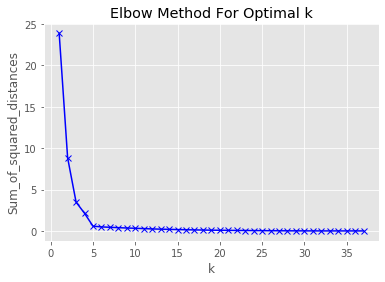

In [55]:
K = range(1,len(Ins_cluster_grp))

plt.plot(K,  elbow,'bx-')
plt.xlabel('k')  
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

##### *Looks like the optimal value is between 0 and 5*

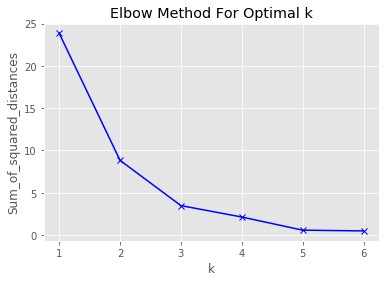

In [56]:
elbow2 = elbow[0:6]
K = range(1,7)
plt.plot(K,  elbow2,'bx-')
plt.xlabel('k')  
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


#### <ins>Optimal K =3, as per the plot. Using 3 to get the clusters </ins>

In [57]:
kclusters = 3
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Ins_cluster_grp)
kmeans.labels_[0:10] 

array([0, 1, 0, 0, 0, 2, 0, 0, 0, 1], dtype=int32)

In [60]:
Neigh_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Neigh_merged = Institute_Neigh

Neigh_merged = Neigh_merged.join(Neigh_venues_sorted.set_index('Area_code'), on='Area_code')

Neigh_merged.head()

,Institute,Ins_Postcode,Ins_Latitude,Ins_Longitude,Borough,Area_code,Area_lat,Area_lng,PTAL,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,Camden,N1C 4,51.536488,-0.125779,6b,0,Café,Coffee Shop,Pub,Burger Joint,Movie Theater,Modern European Restaurant,Breakfast Spot,Plaza,Pizza Place,Park
1,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,Camden,NW1W,51.530784,-0.135426,6b,0,Beer Bar,Cocktail Bar,Italian Restaurant,African Restaurant,Gourmet Shop,Pizza Place,Pub,Chocolate Shop,Music Venue,Museum
2,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,Camden,NW1 0,51.538239,-0.136733,6a,1,Pub,Coffee Shop,Pizza Place,Italian Restaurant,Greek Restaurant,Supermarket,Pharmacy,Beer Bar,Café,Shoe Store
3,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,Camden,NW1 1,51.531571,-0.133216,6b,0,Sandwich Place,Park,Juice Bar,Café,Museum,Chocolate Shop,Burger Joint,Church,Malay Restaurant,Music Venue
4,THE ROYAL VETERINARY COLLEGE,NW1 0TU,51.536862,-0.133498,Camden,NW1 2,51.528193,-0.134248,6b,0,Coffee Shop,Café,Italian Restaurant,Museum,Theater,Science Museum,Beer Bar,Sandwich Place,Breakfast Spot,Gym / Fitness Center


## **`4.Results & Discussion`**

### <ins>Visualizing the clustering of the neighborhoods around the institution</ins> 

In [64]:
address = 'London,UK'

geolocator = Nominatim(user_agent="london_uni_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

In [69]:
cluster_map = folium.Map(location = [latitude, longitude], zoom_start = 10)

folium.Marker([Neigh_merged['Ins_Latitude'][0],Neigh_merged['Ins_Longitude'][0]],popup="Institute").add_to(cluster_map)
              
for lat, lng, code, cluster in zip(Neigh_merged['Area_lat'], Neigh_merged['Area_lng'], Neigh_merged['Area_code'], Neigh_merged['Cluster Labels']):
    label = 'Cluster #: {} Postal Code: {}'.format(cluster,code)
    label = folium.Popup(label, parse_html = True)
    if cluster == 0:
        color="blue" 
    elif cluster == 1:
        color = "magenta"
    else: 
        color="orange"
    folium.CircleMarker([lat, lng], 
                        radius = 4, 
                        popup = label, 
                        color = color,
                        fill = True, 
                        fill_opacity = 0.6, 
                        parse_html = False).add_to(cluster_map)
cluster_map

### <ins>Visualizing the proportion of  neighborhoods in each cluster</ins> 

([<matplotlib.axis.XTick at 0x7f948c2da278>,
 <a list of 3 Text xticklabel objects>)

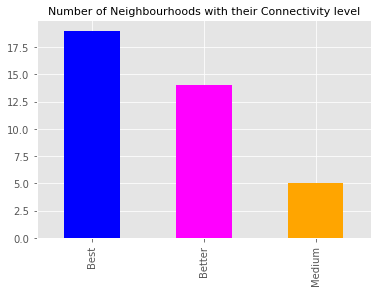

In [66]:
Neigh_merged['Cluster Labels'].value_counts().plot(kind = 'bar', color =['blue', 'magenta', 'orange'])
plt.title('Number of Neighbourhoods with their Connectivity level', fontsize = 11)
plt.xticks(np.arange(3), ('Best', 'Better', 'Medium'))

> From the bar chart we can see that most of the neighbourhoods around The Royal Veterinary College has Good connectivity and would be preferable a preferable location to get an accommodation.

In [116]:
Neigh_merged.loc[Neigh_merged['Cluster Labels'] == 0, Neigh_merged.columns[[1] + list(range(5, Neigh_merged.shape[1]))]]

,Ins_Postcode,Area_code,Area_lat,Area_lng,PTAL,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,NW1 0TU,N1C 4,51.536488,-0.125779,6b,0,Café,Plaza,Pub,Coffee Shop,Pizza Place,Movie Theater,Breakfast Spot,Italian Restaurant,Sandwich Place,Supermarket
1,NW1 0TU,NW1W,51.530784,-0.135426,6b,0,Beer Bar,Italian Restaurant,African Restaurant,Museum,Café,Chocolate Shop,Cocktail Bar,Pub,Pizza Place,Music Venue
3,NW1 0TU,NW1 1,51.531571,-0.133216,6b,0,Coffee Shop,Deli / Bodega,Park,Café,Sandwich Place,Chocolate Shop,Church,Pub,Department Store,Pizza Place
4,NW1 0TU,NW1 2,51.528193,-0.134248,6b,0,Coffee Shop,Café,Museum,Beer Bar,Gym / Fitness Center,Science Museum,Italian Restaurant,Sandwich Place,Breakfast Spot,Theater
5,NW1 0TU,NW1 3,51.527625,-0.140890,6b,0,Coffee Shop,Indian Restaurant,Pub,Gym / Fitness Center,Hotel,Sandwich Place,Park,Platform,Theater,Plaza
7,NW1 0TU,NW1 5,51.521555,-0.161158,6b,0,Pub,Gastropub,Hotel,Movie Theater,Museum,Japanese Restaurant,Pizza Place,Coffee Shop,Thai Restaurant,Mexican Restaurant
8,NW1 0TU,NW1 6,51.523508,-0.162952,6b,0,Café,Pub,Thai Restaurant,Japanese Restaurant,Restaurant,Gastropub,Pizza Place,Hookah Bar,Platform,Seafood Restaurant
9,NW1 0TU,NW1 7,51.537015,-0.144567,6b,0,Coffee Shop,Greek Restaurant,Pub,Cocktail Bar,Pizza Place,Bar,Hotel,Italian Restaurant,Japanese Restaurant,Supermarket
12,NW1 0TU,WC1H,51.526899,-0.125581,6b,0,Café,Coffee Shop,Hotel,Pub,Bakery,Park,Italian Restaurant,Gym,Portuguese Restaurant,Burger Joint
13,NW1 0TU,WC1E,51.521718,-0.132634,6b,0,Coffee Shop,Exhibit,Pizza Place,Bakery,Bar,Organic Grocery,Plaza,Hotel,French Restaurant,Science Museum


In [67]:
Neigh_merged.loc[Neigh_merged['Cluster Labels'] == 1, Neigh_merged.columns[[1] + list(range(5, Neigh_merged.shape[1]))]]

,Ins_Postcode,Area_code,Area_lat,Area_lng,PTAL,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,NW1 0TU,NW1 0,51.538239,-0.136733,6a,1,Pub,Coffee Shop,Pizza Place,Italian Restaurant,Greek Restaurant,Supermarket,Pharmacy,Beer Bar,Café,Shoe Store
10,NW1 0TU,NW1 8,51.542470,-0.149273,6a,1,Pub,Café,Coffee Shop,Market,Yoga Studio,Bar,Pizza Place,Cocktail Bar,Vegetarian / Vegan Restaurant,Flea Market
14,NW1 0TU,WC1X,51.526743,-0.115159,6a,1,Pub,Café,Coffee Shop,Hotel,Vietnamese Restaurant,Park,Pizza Place,History Museum,Garden,Italian Restaurant
16,NW1 0TU,NW5 1,51.557442,-0.144672,6a,1,Café,Italian Restaurant,Pub,Gym / Fitness Center,Music Venue,Pizza Place,Coffee Shop,Convenience Store,Ice Cream Shop,Pool
17,NW1 0TU,NW5 2,51.550526,-0.137276,6a,1,Pub,Grocery Store,Coffee Shop,Cocktail Bar,French Restaurant,Sandwich Place,Bakery,Middle Eastern Restaurant,Food Truck,Café
28,NW1 0TU,W1A 0,51.524567,-0.112017,6a,1,Pub,Garden,Coffee Shop,Cocktail Bar,Hotel,Bar,Park,Middle Eastern Restaurant,Sandwich Place,Café
29,NW1 0TU,W1A 2,51.524565,-0.112042,6a,1,Pub,Garden,Coffee Shop,Cocktail Bar,Hotel,Bar,Park,Middle Eastern Restaurant,Sandwich Place,Café
30,NW1 0TU,W1A 3,51.524179,-0.113526,6a,1,Pub,Coffee Shop,Hotel,Garden,Café,Cocktail Bar,Park,Sandwich Place,Middle Eastern Restaurant,History Museum
31,NW1 0TU,W1A 4,51.524565,-0.112037,6a,1,Pub,Garden,Coffee Shop,Cocktail Bar,Hotel,Bar,Park,Middle Eastern Restaurant,Sandwich Place,Café
32,NW1 0TU,W1A 5,51.524565,-0.112036,6a,1,Pub,Garden,Coffee Shop,Cocktail Bar,Hotel,Bar,Park,Middle Eastern Restaurant,Sandwich Place,Café


In [68]:
Neigh_merged.loc[Neigh_merged['Cluster Labels'] == 2, Neigh_merged.columns[[1] + list(range(5, Neigh_merged.shape[1]))]]

,Ins_Postcode,Area_code,Area_lat,Area_lng,PTAL,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,NW1 0TU,NW1 4,51.529584,-0.143004,5,2,Indian Restaurant,Pub,Hotel,Cocktail Bar,Coffee Shop,Garden,Park,Gym / Fitness Center,Burger Joint,Beer Bar
11,NW1 0TU,NW1 9,51.543824,-0.134331,4,2,Pub,Italian Restaurant,Coffee Shop,Café,Hotel,Canal,French Restaurant,Asian Restaurant,Pizza Place,Park
18,NW1 0TU,NW5 3,51.547660,-0.147388,5,2,Pub,Café,Grocery Store,Coffee Shop,Art Gallery,Pharmacy,Yoga Studio,Discount Store,Rock Club,Recreation Center
19,NW1 0TU,NW5 9,51.550840,-0.146660,5,2,Coffee Shop,Pub,Grocery Store,Pizza Place,French Restaurant,Cocktail Bar,Pharmacy,Sandwich Place,Bakery,Café
20,NW1 0TU,NW5 4,51.550508,-0.152177,3,2,Yoga Studio,Recreation Center,Flea Market,Music Venue,Gastropub,Farm,Bike Shop,Park,Café,Pub


### <ins>Futher Enhancements Recommendation</ins> 

>  There is scope of improving the results to get more granularity in the output
<br>I believe including the following parameters would benefit the results in future:
    <br>
<br> <ins>Average Rent depending on the house type</ins> : Currently this data is available only for a Borough and hence including that would not have given the actual crime rate in a particular neighbourhood. Once the data is available for each of the post codes including that would give a more meaningful data could be derived.
    <br>
<br> <ins>Crime Rate in each Outcode of the neighborhood</ins> : Same is the case for crime rate. The data available is high-level. It wouldn't give a clear picture of crime rate in each neighborhood.
    <br>
    <br> <ins>Average distance from the University</ins>
    <br>Taking these factors into consideration will enhance the results for the students to pin down on exact neighborhoods. As most students look for accommodations in neighborhoods that are close to the university, have better connectivity and is safe

## **`5.Conclusion`**

> The clustering technique divided the neighbourhoods into 3 clusters mainly based on the PTAL index, which assesses the level of walking distances to transport stops and stations, including measuring the level of transport service and wider connectivity. 
    <br>
    <br>Clustering the neighbourhoods based on their connectivity, with Clusters 0 and 1, having the best and better than Cluster 2 which has medium level of connectivity
    <br>
    <br> Further look at the nearby venues listed any student can select the neighbourhood that appeals to their preferences. A student who is a fitness enthusiast and wants to live in a neighborhood with wider connectivity can search for accommdations in neighbourhoods -NW1 3, W1T 7 of Cluster 0 